# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from texttable import Texttable
import latextable

In [11]:
import sys
sys.path.insert(1, '../sar_dirichlet')
import dirichlet_regression

In [14]:
from func_test import cos_similarity, create_features_matrices

In [77]:
scipy.__version__

'1.4.1'

In [5]:
import sys
sys.path.append("../../coral_mapping/")
import segments_regressor
import coral_map_tests

# Loading Maupiti data

In [7]:
X = np.load('../../smote_compositional/data/maupiti_X_for_smote.npy')
Y = np.load('../../smote_compositional/data/maupiti_y_for_smote.npy')
segments = np.load('../../smote_compositional/data/maupiti_segments_for_smote.npy')
indices_segments_keep = np.load('../../smote_compositional/data/maupiti_indices_segments_for_smote.npy')

In [8]:
boundaries = coral_map_tests.find_boundaries(segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(segments, boundaries)

In [9]:
n_features = 16
n_classes = 4
n_samples = X.shape[0]

In [10]:
Y_star = (Y*(n_samples-1)+1/n_classes)/n_samples

In [11]:
# Z only one intercept
Z = np.ones((n_samples,1))
gamma_0 = [0.]

In [11]:
X = StandardScaler().fit(X).transform(X)

In [12]:
# Z a copy of X
Z = np.copy(X)
gamma_0 = np.zeros(n_features)

In [13]:
W = np.zeros((np.max(segments)+1,np.max(segments)+1))
for i in range(np.max(segments)+1):
    W[i,adjacent_segments[i]]=1

In [14]:
W = W[indices_segments_keep][:,indices_segments_keep]

In [15]:
Wsum = W.sum(axis=1)[:,None]
Wsum[Wsum==0] = 1

In [16]:
Wsum = W.sum(axis=1)[:,None]
Wsum[Wsum==0] = 1
W = W/Wsum

In [17]:
np.shape(W)

(2301, 2301)

In [18]:
segments_ind, segments_count = np.unique(segments,return_counts=True)

In [19]:
size_segments = segments_count[indices_segments_keep]

### Not spatial

In [20]:
%%time
dirichRegressor_ns = dirichlet_regression.dirichletRegressor()
dirichRegressor_ns.fit(X, Y_star, parametrization='alternative', gamma_0=gamma_0, Z=Z)

Optimization terminated successfully.
Wall time: 1.16 s


In [21]:
len((dirichRegressor_ns.beta).flatten())+len(gamma_0)

67

In [22]:
print('With Maximum Likelihood')
print('R2:',r2_score(Y_star,dirichRegressor_ns.mu))
print('RMSE:',mean_squared_error(Y_star,dirichRegressor_ns.mu,squared=False))
print('Cross-entropy:',1/n_samples*np.sum(Y_star*np.log(dirichRegressor_ns.mu)))
print('AIC:',-2*dirichlet_regression.dirichlet_loglikelihood(dirichRegressor_ns.mu,dirichRegressor_ns.phi,Y_star)+2*52)
print('Cos similarity:',cos_similarity(Y_star,dirichRegressor_ns.mu))

With Maximum Likelihood
R2: 0.2646356492445391
RMSE: 0.2965322656628067
Cross-entropy: -0.8150346481118759
AIC: -73873.28249791663
Cos similarity: 0.7860420772856085


In [23]:
%%time
dirichRegressor_ns_ce = dirichlet_regression.dirichletRegressor()
dirichRegressor_ns_ce.fit(X, Y_star, parametrization='alternative', gamma_0=gamma_0, Z=Z, loss='crossentropy')

Optimization terminated successfully.
Wall time: 569 ms


In [24]:
print('With Cross-entropy')
print('R2:',r2_score(Y_star,dirichRegressor_ns_ce.mu))
print('RMSE:',mean_squared_error(Y_star,dirichRegressor_ns_ce.mu,squared=False))
print('Cross-entropy:',1/n_samples*np.sum(Y_star*np.log(dirichRegressor_ns_ce.mu)))
print('Cos similarity:',cos_similarity(Y_star,dirichRegressor_ns_ce.mu))

With Cross-entropy
R2: 0.6355086102264353
RMSE: 0.22088013448307742
Cross-entropy: -0.4549141557356628
Cos similarity: 0.8682632703573085


In [25]:
%%time
dirichRegressor_ns_ce_sizes = dirichlet_regression.dirichletRegressor()
dirichRegressor_ns_ce_sizes.fit(X, Y_star, parametrization='alternative', gamma_0=gamma_0, Z=Z, loss='crossentropy',size_samples=size_segments)

Optimization terminated successfully.
Wall time: 12.2 s


In [26]:
print('With Cross-entropy')
print('R2:',r2_score(Y_star,dirichRegressor_ns_ce_sizes.mu))
print('RMSE:',mean_squared_error(Y_star,dirichRegressor_ns_ce_sizes.mu,squared=False))
print('Cross-entropy:',1/n_samples*np.sum(Y_star*np.log(dirichRegressor_ns_ce_sizes.mu)))
print('Cos similarity:',cos_similarity(Y_star,dirichRegressor_ns_ce_sizes.mu))

With Cross-entropy
R2: 0.6283035602726766
RMSE: 0.222911606929354
Cross-entropy: -0.4606353340563921
Cos similarity: 0.8661716061906274


### Spatial

In [27]:
%%time
dirichRegressor_s = dirichlet_regression.dirichletRegressor(spatial=True,maxfun=100000)
dirichRegressor_s.fit(X, Y_star, W=W, parametrization='alternative', rho_0=0.9, gamma_0=gamma_0, Z=Z)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Wall time: 38min 46s


In [28]:
print('With Maximum Likelihood (spatial)')
print('R2:',r2_score(Y_star,dirichRegressor_s.mu))
print('RMSE:',mean_squared_error(Y_star,dirichRegressor_s.mu,squared=False))
print('Cross-entropy:',1/n_samples*np.sum(Y_star*np.log(dirichRegressor_s.mu)))
print('AIC:',-2*dirichlet_regression.dirichlet_loglikelihood(dirichRegressor_s.mu,dirichRegressor_s.phi,Y_star)+2*53)
print('Cos similarity:',cos_similarity(Y_star,dirichRegressor_s.mu))

With Maximum Likelihood (spatial)
R2: 0.44124405924181387
RMSE: 0.2608473361614601
Cross-entropy: -0.6752776971408312
AIC: -74170.49334867197
Cos similarity: 0.8476406493354002


In [29]:
gamma_temp = dirichRegressor_s.gamma
beta_temp = dirichRegressor_s.beta
rho_temp = dirichRegressor_s.rho

In [21]:
rho_temp = 0.9298058277886557
gamma_temp = np.array([-0.05146671, 0.10046038, -0.04784024, 0.03159876, -0.03959053, 0.12628327, 0.01747923, 0.02116901, 
 0.31962639, -0.25221396, 0.0509868, -0.01118039, -0.17163273, 0.0622982,  0.01746982, -0.03163406])
beta_temp = np.array([[-0.01287987, 0.0551159, 0.0246836 ],
 [ 0.04934257, -0.07258876, 0.05351211],
 [-0.10489483, -0.02618882, 0.03409608],
 [-0.03331584, -0.05668082, -0.00582173],
 [-0.03332192, -0.02535768, 0.00706045],
 [-0.10404421, 0.08763152, -0.03416007],
 [ 0.02031442, -0.07781588, 0.12137177],
 [-0.00824716, 0.08102816, -0.12584332],
 [-0.00714535, 0.05568501, -0.10672395],
 [ 0.02885858, 0.02576109, -0.02969467],
 [ 0.07824452, 0.10159564, -0.17817225],
 [-0.03238189, -0.00859438, -0.03618497],
 [-0.01769669, -0.04265948, -0.01857444],
 [-0.01764874, -0.07962339, 0.01174946],
 [-0.02826584, 0.01954204, -0.00215436],
 [-0.00910704, -0.03134357, 0.03088832],
 [ 0.0160624, 0.01677148, -0.03399348]])

In [22]:
%%time
dirichRegressor_s = dirichlet_regression.dirichletRegressor(spatial=True,maxfun=100000)
dirichRegressor_s.fit(X, Y_star, W=W, parametrization='alternative', rho_0=rho_temp, gamma_0=gamma_temp, beta_0=beta_temp, Z=Z)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Wall time: 54.8 s


In [26]:
%%time
dirichRegressor_s_ce = dirichlet_regression.dirichletRegressor(spatial=True)
dirichRegressor_s_ce.fit(X, Y_star, W=W, parametrization='alternative', gamma_0=gamma_0, Z=Z, loss='crossentropy')

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Wall time: 22min 53s


In [65]:
print('With cross entropy (spatial)')
print('R2:',r2_score(Y_star,dirichRegressor_s_ce.mu))
print('RMSE:',mean_squared_error(Y_star,dirichRegressor_s_ce.mu,squared=False))
print('Cross-entropy:',1/n_samples*np.sum(Y_star*np.log(dirichRegressor_s_ce.mu)))
print('Cos similarity:',cos_similarity(Y_star,dirichRegressor_s_ce.mu))

With cross entropy (spatial)
R2: 0.8197360290861662
RMSE: 0.15954589666274704
Cross-entropy: -0.30744064637808155
Cos similarity: 0.9249621893237169


In [28]:
dirichRegressor_s_ce.rho

0.9299245392591207

# Display of the images

In [23]:
from skimage.segmentation import mark_boundaries

In [24]:
B00_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B00.npy')
B01_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B01.npy')
B02_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B02.npy')
B03_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B03.npy')
rugo=np.load('../../water_column/pleiades_rugo.npy')

upperleft_x=573123
upperleft_y=8187427
lowerright_x=584093
lowerright_y=8175645

x_lim_min=574998
x_lim_max=582084
y_lim_min=8177202
y_lim_max=8185046

# On reshape les bandes
B00_corrected=B00_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B01_corrected=B01_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B02_corrected=B02_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B03_corrected=B03_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]

In [25]:
img=np.dstack((B02_corrected, B01_corrected, B00_corrected))

In [26]:
%%time
mask = np.zeros(np.shape(segments))
for i in indices_segments_keep:
    mask[segments == i] = 1

Wall time: 42.7 s


In [27]:
mask = np.array(mask,dtype=bool)
masked_img = np.ma.masked_where(np.dstack(3*[np.bitwise_not(mask)]), img)
mask3 = np.stack((mask,)*3, axis=-1)

In [28]:
marked_boundaries = mark_boundaries(img,segments,color=(1, 0.1, 0.1))

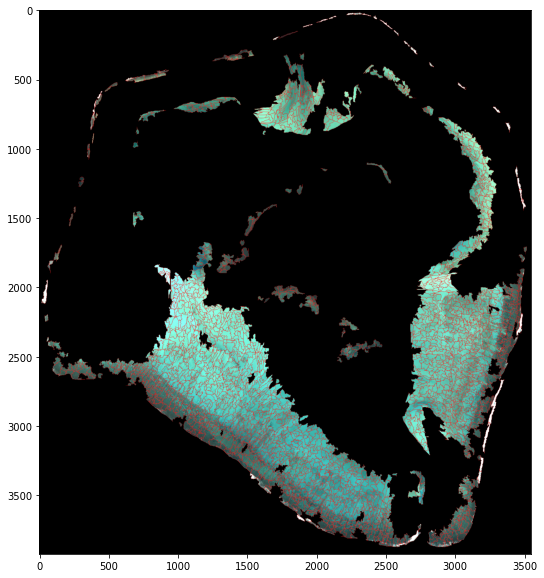

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(marked_boundaries*mask3)
plt.show()

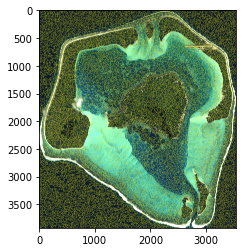

In [26]:
plt.imshow(mark_boundaries(img,segments),interpolation='None')
plt.show()

In [29]:
%%time
map_segments = np.zeros(np.shape(segments))
argmax_Y = np.argmax(Y,axis=1)
for i in range(len(Y)):
    map_segments[segments==indices_segments_keep[i]] = argmax_Y[i]+1

Wall time: 38.2 s


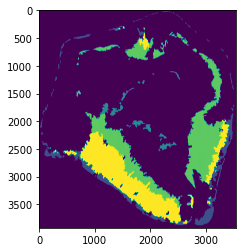

In [30]:
plt.imshow(map_segments)
plt.show()

In [31]:
%%time
map_segments_ns = np.zeros(np.shape(segments))
argmax_mu_ns = np.argmax(dirichRegressor_ns.mu,axis=1)
for i in range(len(Y)):
    map_segments_ns[segments==indices_segments_keep[i]] = argmax_mu_ns[i]+1

Wall time: 41.5 s


In [32]:
np.sum(map_segments_ns[map_segments!=0] == map_segments[map_segments!=0])/np.sum(map_segments!=0)

0.7518323938720787

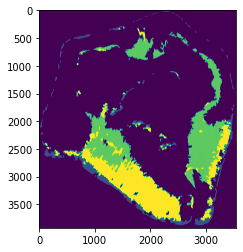

In [33]:
plt.imshow(map_segments_ns)
plt.show()

In [34]:
%%time
map_segments_s = np.zeros(np.shape(segments))
argmax_mu_s = np.argmax(dirichRegressor_s.mu,axis=1)
for i in range(len(Y)):
    map_segments_s[segments==indices_segments_keep[i]] = argmax_mu_s[i]+1

Wall time: 47.5 s


In [35]:
np.sum(map_segments_s[map_segments!=0] == map_segments[map_segments!=0])/np.sum(map_segments!=0)

0.8321809105971737

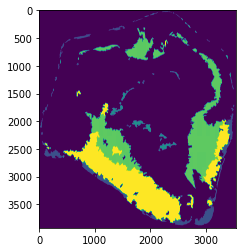

In [36]:
plt.imshow(map_segments_s)
plt.show()

In [103]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

cMap = []
for value, colour in zip([0,1,2,3,4],["tab:grey", "tab:orange", "tab:pink", "tab:blue", "tab:green"]):
    cMap.append((value/4, colour))

customColourMap = LinearSegmentedColormap.from_list("custom", cMap)

bounds = np.linspace(0, 5, 6)
norm = mpl.colors.BoundaryNorm(bounds, customColourMap.N)

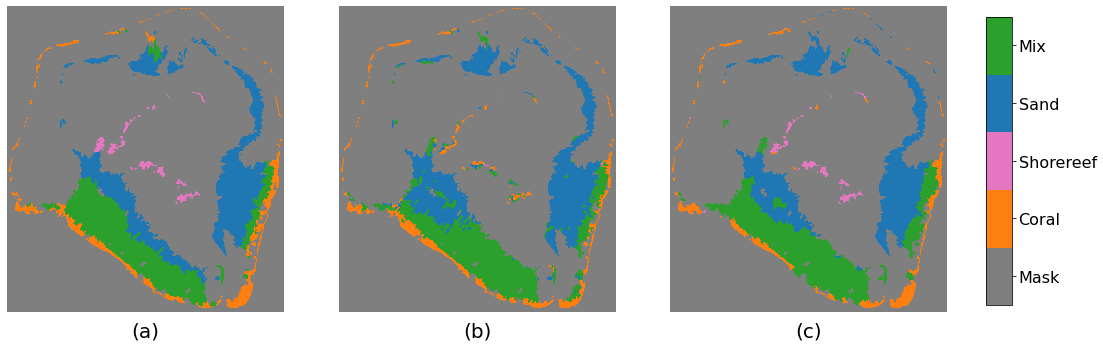

In [110]:
fig,ax = plt.subplots(1,3,figsize=(18,8))

im0 = ax[0].imshow(map_segments, interpolation='None', cmap=customColourMap, norm=norm)
ax[0].axis('off')
#ax[0].set_title('Ground-truth image')
ax[0].set_title('(a)', y=-0.1, fontsize=20)

ax[1].imshow(map_segments_ns, interpolation='None', cmap=customColourMap, norm=norm)
ax[1].axis('off')
#ax[1].set_title('With non-spatial Dirichlet model (accuracy=0.752)')
ax[1].set_title('(b)', y=-0.1, fontsize=20)

ax[2].imshow(map_segments_s, interpolation='None', cmap=customColourMap, norm=norm)
ax[2].axis('off')
#ax[2].set_title('With spatial Dirichlet model (accuracy=0.832)')
ax[2].set_title('(c)', y=-0.1, fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(im0, cax=cbar_ax, ticks=.5+np.arange(5))
cbar_ax.set_yticklabels(['Mask', 'Coral', 'Shorereef', 'Sand', 'Mix'], size=16)
plt.savefig('maps_reconstructed_abc_legend.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()